# MCMC Polynomial Fitting
- Phase Variation = 1st or 2nd order sinusoid
- Polynomial = 2nd-5th order polynomial
- Can also do ellipsoidal varations

# Astrophysical Model

- Transit = stellar flux
- $F_p$ = $\Phi (t)$ x $(E(t)-1)$

In [1]:
'''Import Package'''

import scipy
import scipy.stats as sp
import scipy.optimize as spopt

import emcee
import batman
import corner

import numpy as np
import time as t
import os, sys
import csv

lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

import helpers
import astro_models
import make_plots
import make_plots_custom
import detec_models

import inspect

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

import astropy.time
from astropy.stats import sigma_clip
from astropy.table import Table, Column

%matplotlib inline

In [2]:
user = 'Lisa'

In [3]:
'''SETUP for Taylor'''
if user == 'Taylor':
    planet   = 'WASP-12b'            # Name of the planet

    channel  = 'ch2'                 # Spitzer channel
    mode     = 'Poly2_v1_ellipseOffset'    # Detector model and Phase variation order
    if planet=='WASP-12b':
        if channel=='ch2':
            phoption = '4umHardCircular3_2'  # photometry option
        else:
            phoption = '3umExactCircular4_5' # photometry option
    else:
        if channel=='ch2':
            phoption = '4umHardCircular2_5'  # photometry option
        else:
            phoption = '3umHardCircular4_5'  # photometry option
    nFrames  = 64                    # number of frames per binned data point
    initializeWithOld = False        # initial with previous mcmc results
    runMCMC = False                  # whether to run MCMC or just load-in past results
    nBurnInSteps = 3e5               # number of steps to use for each mcmc burn-in
    nProductionSteps = 6e5           # number of steps to use with mcmc production run
    usebestfit = False               # used best-fit instead of most probable parameters 
    
    # Master path
    mainpath   = '/home/taylor/Documents/Research/spitzer/'+planet+'/analysis/'
    # path where outputs are saved
    foldername = mainpath + channel +'/' + phoption + '/'
    savepath   = foldername + mode + '/'
    if not os.path.exists(savepath):
        os.makedirs(savepath)
    # path to photometry outputs
    filename   = channel + '_datacube_binned_AORs4801.dat'
    filenamef  = channel + '_datacube_full_AORs4801.dat'
    # Path to previous mcmc results (optional)
    path_params = ''   # path to previous mcmc results
    
    if planet == 'WASP-12b':
        if channel=='ch1':
            timeaor1 = 56638.7346502+1/3600/24  #Taken from BMJD from 1st file of 2nd aor
            timeaor2 = 56639.234842+1/3600/24   #Taken from BMJD from 1st file of 3nd aor

            ignoreFrames = [0,1]

        else:
            timeaor1 = 56641.9990393+1/3600/24  #Taken from BMJD from 1st file of 2nd aor
            timeaor2 = 56642.4991651+1/3600/24  #Taken from BMJD from 1st file of 3nd aor

            ignoreFrames = [0,1]
        breaks = np.array([timeaor1, timeaor2])
    else:
        if channel=='ch1':
            timeaor1 = 55518.1649117+1/3600/24  #Taken from BMJD from 1st file of 2nd aor

            ignoreFrames = [0]

        else:
            timeaor1 = 55542.196255+1/3600/24  #Taken from BMJD from 1st file of 2nd aor

            ignoreFrames = [0]
        breaks = np.array([timeaor1])

    breaks = np.array([timeaor1, timeaor2])

    # non-zero if you cut initial data set (DANGER)
    cut = 0

In [4]:
if user=='Taylor':
    
    # parameter you do not wish to fit
    dparams = ['per','ecosw','esinw']
    
    # make params obj
    p0_obj  = helpers.signal_params() 

    # Personalize object default object values
    p0_obj.name = planet                          # name of the planet
    
    p0_obj.t0    = 56176.168258                    # BMJD time
    p0_obj.per   = 1.0914203                       # in days
    p0_obj.rp    = 0.11785                         # planetary radius (in stellar radii) 
    p0_obj.a     = 3.039                           # orbital semi-major axis (in stellar radii)
    p0_obj.inc   = 83.37                           # in degrees: 90 = edge-on                
    p0_obj.ecosw = 0                               # ecc and w # np.cos only takes rad
    p0_obj.esinw = 0                               # ecc and w # np.sin only takes rad
    p0_obj.q1    = 0.1
    p0_obj.q2    = 0.1
    p0_obj.fp    = 0.004                           # eclipse depth in units of stellar flux
    
    p0_obj.A    = 0.1
    p0_obj.B    = 0.0
    
    p0_obj.r2    = p0_obj.rp
    p0_obj.r2off = 0.0
    
    p0_obj.sigF = 0.001
    
    p0_obj.mode = mode
    
    #lnprior_custom = 'none'
    
    priors = [56176.168258, 3.039, 83.37]
    errs = [0.00007765,0.0335,0.68]
    
    if 'ellipse' in mode:
        def lnprior_custom_taylor(t0, a, i, rp, r2, r2off, priors, errs):
            if r2 > 0 and r2 < 3*rp and -90 < r2off < 90:
                t0_prior = -0.5*(((t0 - priors[0])/errs[0])**2.0)
                a_prior = -0.5*(((a - priors[1])/errs[1])**2.0)
                i_prior = -0.5*(((i - priors[2])/errs[2])**2.0)
                return t0_prior+a_prior+i_prior
            else:
                return -np.inf
        
        if 'r2off' not in dparams:
            lnprior_custom = lambda p0: lnprior_custom_taylor(p0[np.where(p0_labels=='t0')[0][0]], p0[np.where(p0_labels=='a')[0][0]], p0[np.where(p0_labels=='inc')[0][0]], p0[np.where(p0_labels=='rp')[0][0]], p0[np.where(p0_labels=='r2')[0][0]], p0[np.where(p0_labels=='r2off')[0][0]], priors, errs)
        else:
            lnprior_custom = lambda p0: lnprior_custom_taylor(p0[np.where(p0_labels=='t0')[0][0]], p0[np.where(p0_labels=='a')[0][0]], p0[np.where(p0_labels=='inc')[0][0]], p0[np.where(p0_labels=='rp')[0][0]], p0[np.where(p0_labels=='r2')[0][0]], 0, priors, errs)
            
    else:
        def lnprior_custom_taylor(t0, a, i, priors, errs):
            t0_prior = -0.5*(((t0 - priors[0])/errs[0])**2.0)
            a_prior = -0.5*(((a - priors[1])/errs[1])**2.0)
            i_prior = -0.5*(((i - priors[2])/errs[2])**2.0)
            return t0_prior+a_prior+i_prior
        
        lnprior_custom = lambda p0: lnprior_custom_taylor(p0[np.where(p0_labels=='t0')[0][0]], p0[np.where(p0_labels=='a')[0][0]], p0[np.where(p0_labels=='inc')[0][0]], priors, errs)

In [18]:
if user == 'Lisa':
    planet   = 'XO-3b'                         # Name of the planet
    channel  = 'ch1'                           # Spitzer channel
    mode     = 'Poly4_v2_eccent_psfw'          # Detector model and Phase variation order
    if channel == 'ch1':
        phoption = '3umFixedCenterCircular6_25'# photometry option
    else:
        phoption = '4umFixedCenterCircular3_75'# photometry option
    nFrames  = 64                              # number of frames per binned data point
    initializeWithOld = True                   # initial with previous mcmc results
    runMCMC = True                             # whether to run MCMC or just load-in past results
    nBurnInSteps = 3e5                         # number of steps to use for each mcmc burn-in
    nProductionSteps = 6e5                     # number of steps to use with mcmc production run
    usebestfit = True                          # used best-fit instead of most probable parameters 

    # Master path
    mainpath   = '/volumes/Seagate Expansion Drive/Research/XO-3b/'
    # path where outputs are saved
    foldername = mainpath + channel +'/Analysis/' + phoption + '/' 
    # create directory for your mode
    savepath    = foldername + mode + '/'
    if not os.path.exists(savepath): os.makedirs(savepath)
    # path to photometry outputs
    filename   = channel + '_datacube_binned_AORs464.dat'
    filenamef  = channel + '_datacube_full_AORs464.dat'
    # Path to previous mcmc results (optional)
    #path_params = foldername + 'Poly2_v1_eccent_psfw_trim/ResultMCMC_Poly2_v1_eccent_psfw_trim_Params.npy'
    path_params = foldername + 'Poly4_v1_eccent_psfw/ResultMCMC_Poly4_v1_eccent_psfw_Params.npy'

    # I removed the first 12 datacubes (calibration data)
    cut = 11
    # breaks from on AOR to another (luckily same for both channels)
    ind_AOR = [11,343,676,1009,1333,1675,2008,2341,2398]
    # frames to be ignored according to the frames systematics
    if channel == 'ch1':
        ignoreFrames = [0,1,2]
    elif channel == 'ch2':
        ignoreFrames = [0]

In [19]:
if user=='Lisa':
    # parameter you do not wish to fit
    dparams = ['per', 'a', 'inc', 'ecosw', 'esinw']
    
    # make params obj
    p0_obj  = helpers.signal_params() 
    
    # Some definition for XO-3b
    r_star            = 1.377                    # for XO-3 in solar radius
    r_sol2jup         = 0.10049                  # jupiter radius in solar radius
    r_sol2AU          = 214.93946938             # AU radius in solar radius

    # Personalize object default object values
    p0_obj.name = planet                          # name of the planet
    
    p0_obj.per  = 3.1915239                       # in days
    p0_obj.rp   = 0.125/r_star                    # planetary radius (in solar radius)/stellar radius (solar radius) 
    p0_obj.a    = 0.0454*r_sol2AU/r_star          # 
    p0_obj.inc  = 84.20                           # 90 = edge-on                
    p0_obj.ecosw= 0.277*np.cos(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.cos only takes rad
    p0_obj.esinw= 0.277*np.sin(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.sin only takes rad
    p0_obj.q1   = 0.001
    p0_obj.q2   = 0.001
    p0_obj.fp   = 0.001                           # eclipse depth in units of stellar flux
    
    p0_obj.A    = 0.1
    p0_obj.B    = 0.0
    
    if channel == 'ch1':
        peritime    = 56395.57202659136
        p0_obj.t0   = 56396.20277778              # BMJD time
        
    if channel == 'ch2':
        peritime    = 56417.90827381378
        p0_obj.t0   = 56418.540                   # BMJD time
    
    p0_obj.r2   = p0_obj.rp 
    p0_obj.mode = mode

    # define priors
    # define priors
    if channel == 'ch1':
        def lnprior_custom(p0):
            t0,rp,q1,q2,fp,A,B,C,D,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,d1,d2,d3,sigF = p0
            # gaussian prior for per
            #lgpri_per = -0.5*(((per - 3.1915325)/0.0000006)**2.0)
            # gaussian prior for a
            #lgpri_a = -0.5*(((a - 7.07)/0.31)**2.0)
            # gaussian prior for i
            #lgpri_i = -0.5*(((inc - 84.11)/0.16)**2.0)
            # gaussian prior for ecosw
            #lgpri_ecosw = -0.5*(((ecosw - 0.27005)/0.00026)**2.0)
            # gaussian prior for esinw
            #lgpri_esinw = -0.5*(((esinw +  0.0612)/0.0083)**2.0)
            # uniform prior for the rest
            if (56396.15 < t0 < 56396.25):
                return 0.0 #+ lgpri_a + lgpri_i + lgpri_ecosw + lgpri_esinw + lgpri_per
            return -np.inf
    
    if channel == 'ch2':
        def lnprior_custom(p0):
            t0,rp,q1,q2,fp,A,B,C,D,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,d1,d2,d3,sigF = p0
            # gaussian prior for per
            #lgpri_per = -0.5*(((per - 3.1915325)/0.0000006)**2.0)
            # gaussian prior for a
            #lgpri_a = -0.5*(((a - 7.07)/0.31)**2.0)
            # gaussian prior for i
            #lgpri_i = -0.5*(((inc - 84.11)/0.16)**2.0)
            # gaussian prior for ecosw
            #lgpri_ecosw = -0.5*(((ecosw - 0.27005)/0.00026)**2.0)
            # gaussian prior for esinw
            #lgpri_esinw = -0.5*(((esinw +  0.0612)/0.0083)**2.0)
            # uniform prior for the rest
            if (56418.4 < t0 < 56418.6):
                return 0.0 #+ lgpri_a + lgpri_i + lgpri_ecosw + lgpri_esinw + lgpri_per
            return -np.inf

In [20]:
if 'poly' in mode.lower():
    detecModel = detec_models.detec_model_poly
else:
    raise NotImplementedError('Only polynomial models are currently implemented! \nmode=\''+mode+'\' does not include \'poly\' or \'Poly\'.')

# Everything below is now automated

In [21]:
# labels for all the possible fit parameters
p0_names = np.array(['t0', 'per', 'rp', 'a', 'inc', 'ecosw', 'esinw', 'q1', 'q2', 'fp', 
                    'A', 'B', 'C', 'D', 'r2', 'r2off', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7',
                     'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17',
                     'c18', 'c19', 'c20', 'c21', 'd1', 'd2', 'd3', 'sigF'])

# fancy labels for plot purposed  for all possible fit parameters
p0_fancyNames = np.array([r'$t_0$', r'$P_{\rm orb}$', r'$R_p/R_*$', r'$a/R_*$', r'$i$', r'$e \cos(\omega)$',
                          r'$e \sin(\omega)$', r'$q_1$', r'$q_2$', r'$f_p$', r'$A$', r'$B$',
                          r'$C$', r'$D$', r'$R_{p,2}/R_*$', r'$R_{p,2}/R_*$ Offset', r'$C_1$', r'$C_2$', r'$C_3$',
                          r'$C_4$', r'$C_5$', r'$C_6$', r'$C_7$', r'$C_8$', r'$C_9$',
                          r'$C_{10}$', r'$C_{11}$', r'$C_{12}$', r'$C_{13}$', r'$C_{14}$',
                          r'$C_{15}$', r'$C_{16}$', r'$C_{17}$', r'$C_{18}$', r'$C_{19}$',
                          r'$C_{20}$', r'$C_{21}$',r'$D_1$', r'$D_2$', r'$D_3$', r'$\sigma_F$'])

In [22]:
# loading full data set for BIC calculation afterwards
data_full = helpers.get_full_data(foldername, filenamef)

# sigma clip the data
flux_full, time_full, xdata_full, ydata_full, psfxw_full, psfyw_full = helpers.clip_full_data(*data_full, nFrames, cut, ignoreFrames)
mid_x_full, mid_y_full = np.nanmean(xdata_full), np.nanmean(ydata_full)

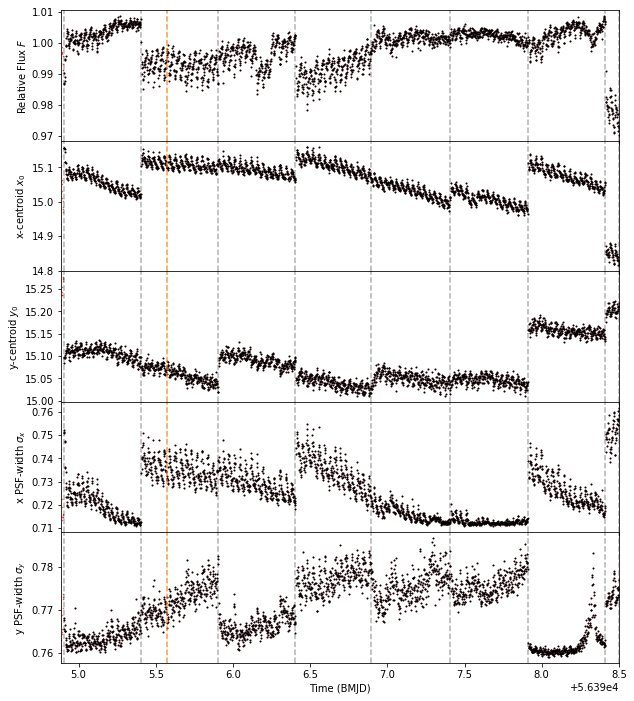

In [23]:
# Get Data
data = helpers.get_data(foldername+filename)
# Sort data
flux0, flux_err0, time0, xdata0, ydata0, psfxw0, psfyw0 = helpers.time_sort_data(*data)
# Trim AOR
flux, flux_err, time, xdata, ydata, psfxw, psfyw = helpers.time_sort_data(*data, cut=cut)
# pre-calculation
mid_x, mid_y = np.mean(xdata), np.mean(ydata)

# get AOR delimitation (TO BE REMOVED)
if user=='Taylor':
    breaks = np.array([timeaor1, timeaor2])
    # make photometry plots
    make_plots.plot_photometry(time0, flux0, xdata0, ydata0, psfxw0, psfyw0, 
                    time, flux, xdata, ydata, psfxw, psfyw, breaks, savepath)
    
if user=='Lisa':
    breaks = np.empty(len(ind_AOR))
    for i in range(len(ind_AOR)):
        breaks[i] = time0[ind_AOR[i]]
    # plot raw data
    make_plots.plot_photometry(time0, flux0, xdata0, ydata0, psfxw0, psfyw0, 
                    time, flux, xdata, ydata, psfxw, psfyw, breaks, savepath, peritime)

In [24]:
# redefining the zero centroid position
xdata -= mid_x
ydata -= mid_y
xdata_full -= mid_x_full
ydata_full -= mid_y_full

In [25]:
# True if user wants details about the lambda functions created
debug = False

# makes list of parameters that won't be fitted 
dparams = helpers.expand_dparams(dparams, mode)  

# if you want to use the best fit params from a previous MCMC run
if initializeWithOld == True:
    Table_par = np.load(path_params)                  # table of best-fit params from prev. run
    index     = np.in1d(p0_names, dparams)            # get the index list of params to be fitted
    nparams   = p0_names[np.where(index==False)[0]]   # get the name list of params to be fitted
    for name in nparams:
        cmd = 'p0_obj.' + name + ' = ' + 'Table_par[\'' + name + '\'][0]'
        try:
            exec(cmd)
        except Exception as e:
            print("type error: " + str(e))            # catch errors if you use values from fun with less params

type error: no field of name C
type error: no field of name D


In [26]:
# get p0
obj = p0_obj
p0, p0_labels, p0_fancyLabels = helpers.get_p0(p0_names, p0_fancyNames, dparams, p0_obj)
p0_signal  = p0
if 'sigF' in p0_labels:
    p0_signal = p0_signal[:-1]

# make lambda function
signalfunc = helpers.make_lambdafunc(helpers.signal_poly, dparams, p0_obj, debug=debug)
if debug:
    print()

# making lambda function for phasecurve and detector
astrofunc = helpers.make_lambdafunc(astro_models.ideal_lightcurve, dparams, p0_obj, debug=debug)
print()
if debug:
    print()
    
detecfunc = helpers.make_lambdafunc(detec_models.detec_model_poly, dparams, p0_obj, debug=debug)
if debug:
    print()
    
psfwifunc = helpers.make_lambdafunc(detec_models.detec_model_PSFW, dparams, p0_obj, debug=debug)
if debug:
    print()

# make a lnprior lambda function
lnpriorfunc = helpers.make_lambdafunc(helpers.lnprior, dparams, obj=p0_obj, debug=debug)

# detemining which params in p0 is part of ideal_lightcurve, detec, psfw
p0_detec  = inspect.getargspec(detec_models.detec_model_poly).args[1:]
p0_deval, p0_detec, p0_detecFancy  = helpers.get_p0(p0_detec, p0_fancyNames, dparams,p0_obj)

p0_psfwi  = inspect.getargspec(detec_models.detec_model_PSFW).args[1:]
p0_psval, p0_psfwi, p0_psfwiFancy  = helpers.get_p0(p0_psfwi, p0_fancyNames, dparams,p0_obj)

p0_astro  = inspect.getargspec(astro_models.ideal_lightcurve).args[1:-1]
p0_asval, p0_astro, p0_astroFancy  = helpers.get_p0(p0_astro, p0_fancyNames, dparams,p0_obj)

## Getting initial detector params guesses

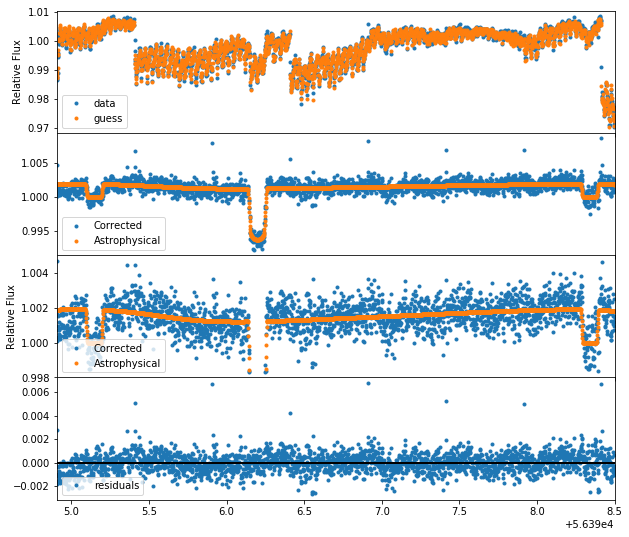

In [27]:
# initial astro model
astro_guess = astrofunc(time, *p0_asval, mode)
resid       = flux/astro_guess

if initializeWithOld == False:
    # get initial guess for detec model
    p0_deval, _ = scipy.optimize.curve_fit(detecfunc, (xdata, ydata, mode), resid, p0_deval)
    detec_guess = detecfunc((xdata, ydata, mode), *p0_deval)
    resid       = resid/detec_guess

    # replace p0 with new detector coefficient values
    for i in range(len(p0_detec)):
        index = np.where(np.in1d(p0_labels,p0_detec[i]))
        p0[index] = p0_deval[i]
        mystr = 'p0_obj.' + p0_detec[i] + '=' + str(p0_deval[i])
        exec(mystr)

    if 'psfw' in mode:
        # get initial guess for psfw model
        p0_psval, _ = scipy.optimize.curve_fit(psfwifunc, (psfxw, psfyw), resid, p0_psval)
        psfwi_guess = psfwifunc((psfxw, psfyw), *p0_psval)
        resid       = resid/psfwi_guess

        for i in range(len(p0_psfwi)):
            index = np.where(np.in1d(p0_labels,p0_psfwi[i]))
            p0[index] = p0_psval[i]
            mystr = 'p0_obj.' + p0_psfwi[i] + '=' + str(p0_psval[i])
            exec(mystr)
    else:
        psfwi_guess = psfwifunc((psfxw, psfxw))
else:
    detec_guess = detecfunc((xdata, ydata, mode), *p0_deval)
    psfwi_guess = psfwifunc((psfxw, psfyw), *p0_psval)
    
# initial guess
signa_guess = signalfunc(time, xdata, ydata, psfxw, 
                         psfyw, mode, *p0_signal)
    
# plot detector initial guess
make_plots.plot_init_guess(time, flux, signa_guess, astro_guess,
                           detec_guess, psfwi_guess, savepath)

## Preparing for MCMC

In [35]:
ndim, nwalkers = len(p0), 300

if runMCMC:
    # get scattered starting point in parameter space 
    # MUST HAVE THE INITIAL SPREAD SUCH THAT EVERY SINGLE WALKER PASSES lnpriorfunc AND lnprior_custom
    '''pos0 = [p0*(1+1e-5*np.random.randn(ndim))+1e-5*np.abs(np.random.randn(ndim)) for i in range(nwalkers)]

    checkPhasePhis = np.linspace(-np.pi,np.pi,1000)

    #sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, helpers.lnprob, a = 2,
                                    args=(signalfunc, lnpriorfunc, 
                                          flux, time, xdata, ydata, psfxw, psfyw,
                                          mode, checkPhasePhis, lnprior_custom))

    if lnpriorfunc(*p0, mode, checkPhasePhis) != 0.0 or (lnprior_custom != 'none' and lnprior_custom(p0) != 0.0):
        print('Error: Initial values fail the lnprior and the following MCMC will not work!')
    
    
    #First burn-in:
    tic = t.time()
    print('Running burn-in')
    pos1, prob, state = sampler.run_mcmc(pos0, np.rint(nBurnInSteps/nwalkers))
    print("Mean burn-in acceptance fraction: {0:.3f}"
                    .format(np.mean(sampler.acceptance_fraction)))
    sampler.reset()
    toc = t.time()
    print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))
    
    
    #Second burn-in
    #Continue from best spot from last time, and do quick burn-in to get walkers spread out
    tic = t.time()
    print('Running second burn-in')
    pos2 = pos1[np.argmax(prob)]
    # slightly change position of walkers to prevent them from taking the same path
    pos2 = [pos2*(1+1e-6*np.random.randn(ndim))+1e-6*np.abs(np.random.randn(ndim)) for i in range(nwalkers)]
    pos2, prob, state = sampler.run_mcmc(pos2, np.rint(nBurnInSteps/nwalkers))
    print('Mean burn-in acceptance fraction: {0:.3f}'
                    .format(np.median(sampler.acceptance_fraction)))
    sampler.reset()
    toc = t.time()
    print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))'''
    
    
    #Run production
    #Run that will be saved
    sampler.reset()
    tic = t.time()
    # Continue from last positions and run production
    print('Running production')
    pos3, prob, state = sampler.run_mcmc(pos3, np.rint(nProductionSteps/nwalkers))
    print("Mean acceptance fraction: {0:.3f}"
                    .format(np.mean(sampler.acceptance_fraction)))
    toc = t.time()
    print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))
    
    
    #Saving MCMC Results
    pathchain = savepath + 'samplerchain_'+mode+'.npy'
    pathposit = savepath + 'samplerposi_'+mode+'.npy'
    pathlnpro = savepath + 'samplerlnpr_'+mode+'.npy'
    np.save(pathchain, sampler.chain)
    np.save(pathposit, pos3)
    np.save(pathlnpro, pos3)
    
    chain = sampler.chain
    
else:
    
    pathchain = savepath + 'samplerchain_'+mode+'.npy'
    chain = np.load(pathchain)
    pathlnpro = savepath + 'samplerlnpr_'+mode+'.npy'
    lnprobability = np.load(pathlnpro)

samples = chain.reshape((-1, ndim))

Running production
Mean acceptance fraction: 0.159
MCMC runtime = 24.10 min



## Remove Outliers Walkers
mostly outliers in time of transit

Number of params group deleted: 6000


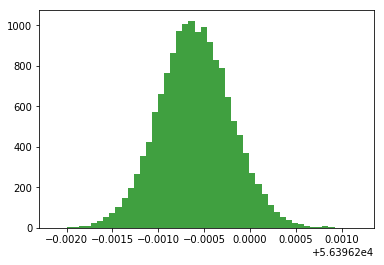

In [36]:
if user == 'Lisa':
    # copy to not compromise
    t0walkers = np.copy(samples[:,0])
    # get index for params group with t0 out of range
    if channel == 'ch1':
        index = np.where(np.logical_or(t0walkers<=56396.15, t0walkers>=56396.25))
    elif channel == 'ch2':
        index = np.where(np.logical_or(t0walkers<=56418.4, t0walkers>=56418.6))
    print('Number of params group deleted:', len(index[0]))
    # replace samples with samples without bad group
    samplescopy = np.copy(samples)
    samples  = np.delete(samplescopy, index[0], axis=0)
    # plot histogram to see if you have been successful 
    n, bins, patches = plt.hist(samples[:,0], 50, density=True, facecolor='g', alpha=0.75)

## Fold inclination back around since i>90 is meaningless

In [37]:
if 'inc' in p0_labels:
    pos_inc = np.where(p0_labels == 'inc')[0][0]
    samples[np.where(samples[:,pos_inc] > 90)[0],pos_inc] = 180 - samples[np.where(samples[:,pos_inc] > 90)[0],pos_inc]

In [38]:
#print the results

(MCMC_Results) = list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0))))
p0_mcmc = np.median(samples, axis=0)

# taking max lnprob params instead of median bc degeneracy

if usebestfit == True: 
    if runMCMC == True:
        maxk, maxiter = np.unravel_index((sampler.lnprobability).argmax(), (sampler.lnprobability).shape)
        p0_mcmc = sampler.chain[maxk, maxiter,:]
    else:
        maxk, maxiter = np.unravel_index((lnprobability).argmax(), (lnprobability).shape)
        p0_mcmc = chain[maxk, maxiter,:]
    for i in range(len(p0_mcmc)):
        MCMC_Results[i] = (p0_mcmc[i], MCMC_Results[i][1], MCMC_Results[i][2])

In [39]:
out = "MCMC result:\n\n"
for i in range(len(p0)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])

if ('A' in p0_labels)  and ('B' in p0_labels) and ('C' not in p0_labels) and ('D' not in p0_labels):
    A = p0_mcmc[np.where(p0_labels == 'A')[0][0]]
    B = p0_mcmc[np.where(p0_labels == 'B')[0][0]]
    out += '{:>8} = {:>16} degrees east\n'.format('Offset', -np.arctan(B/A)*180/np.pi)
elif ('A' in p0_labels)  and ('B' in p0_labels) and ('C' in p0_labels) and ('D' in p0_labels):
    A = p0_mcmc[np.where(p0_labels == 'A')[0][0]]
    B = p0_mcmc[np.where(p0_labels == 'B')[0][0]]
    C = p0_mcmc[np.where(p0_labels == 'C')[0][0]]
    D = p0_mcmc[np.where(p0_labels == 'D')[0][0]]
    phis = np.linspace(-np.pi,np.pi,1000)
    offset = phis[np.argmax(1 + A*(np.cos(phis)-1) + B*np.sin(phis) + C*(np.cos(2*phis)-1) + D*np.sin(2*phis))]*180/np.pi
    out += '{:>8} = {:>16} degrees east\n'.format('Offset', -offset)

if ('ellipse' in mode) and ('rp' in p0_labels) and ('r2' in p0_labels):
    out += '{:>8} = {:>16}'.format('R2/Rp', p0_mcmc[np.where(p0_labels == 'r2')[0][0]]/p0_mcmc[np.where(p0_labels == 'rp')[0][0]])

print(out)
with open(savepath+'MCMC_RESULTS_'+mode+'.txt','w') as file:
    file.write(out) 

MCMC result:

      t0 = 56396.19949002087  +0.00039579968142788857  -0.0003823505321634002
      rp = 0.08628996516416554  +0.0008415127286042073  -0.0008143653155203573
      q1 = 0.17438042398335377  +0.07817863810799794  -0.06539106629088787
      q2 = 0.343983463396912  +0.2999204350894416  -0.15440003465573665
      fp = 0.0018708563914193942  +0.0001047050354997432  -0.00010429042370328138
       A = 0.165497469566803  +0.023260910392754963  -0.022892915977903744
       B = 0.04695765825069106  +0.02873687362319781  -0.028385326428139183
       C = 0.03187633398544523  +0.028970457738218255  -0.027873731029650586
       D = 0.15557793780482776  +0.024276106145409676  -0.022455557568126033
      c1 = 1.0515544087743847  +0.013332939314637526  -0.013679882609060279
      c2 = -0.07054259601665742  +0.006068793596662528  -0.006117541788505473
      c3 = 0.010427771226320345  +0.0031885891683039232  -0.0031859764316647266
      c4 = -0.6405335315585017  +0.041645047033609606  -0.041

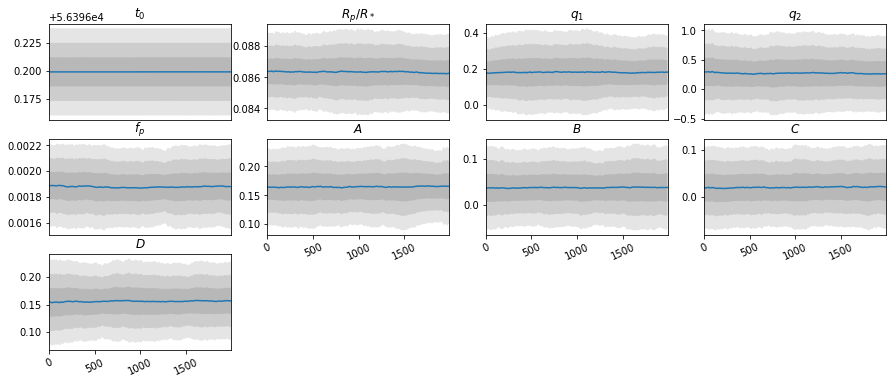

In [40]:
ind_a = len(p0_astro) # index where the astro params
ind_d = len(p0_astro) + len(p0_detec)
ind_p = len(p0_astro) + len(p0_detec) + len(p0_psfwi)

labels = p0_fancyLabels[:ind_a]

fname = savepath+'MCMC_'+mode+'_astroWalkers.pdf'
helpers.walk_style(ind_a, nwalkers, chain, 10, int(np.rint(nProductionSteps/nwalkers)), labels, fname)

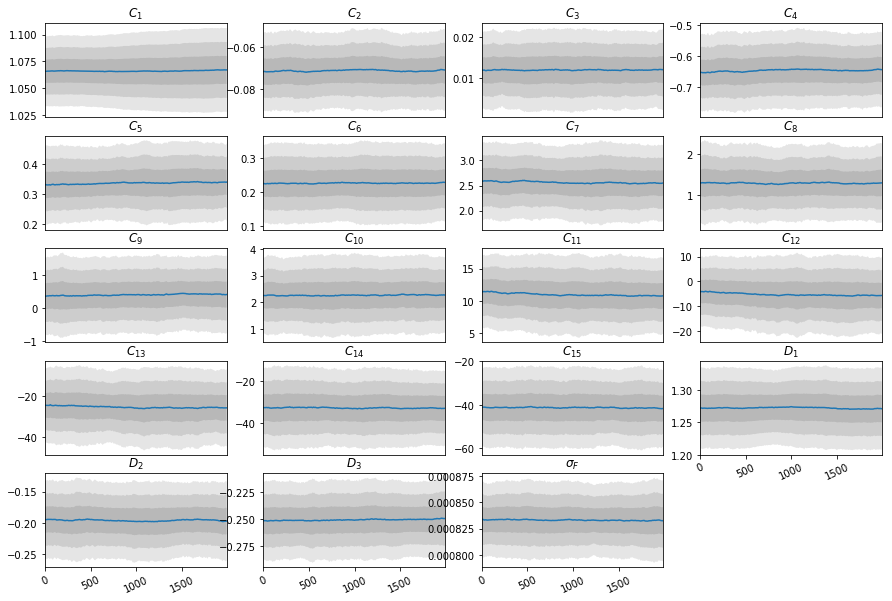

In [41]:
labels = p0_fancyLabels[ind_a:]
fname = savepath+'MCMC_'+mode+'_detecWalkers.pdf'
helpers.walk_style(len(p0)-ind_a, nwalkers, chain[:,:,ind_a:], 10, int(np.rint(nProductionSteps/nwalkers)), labels, fname)

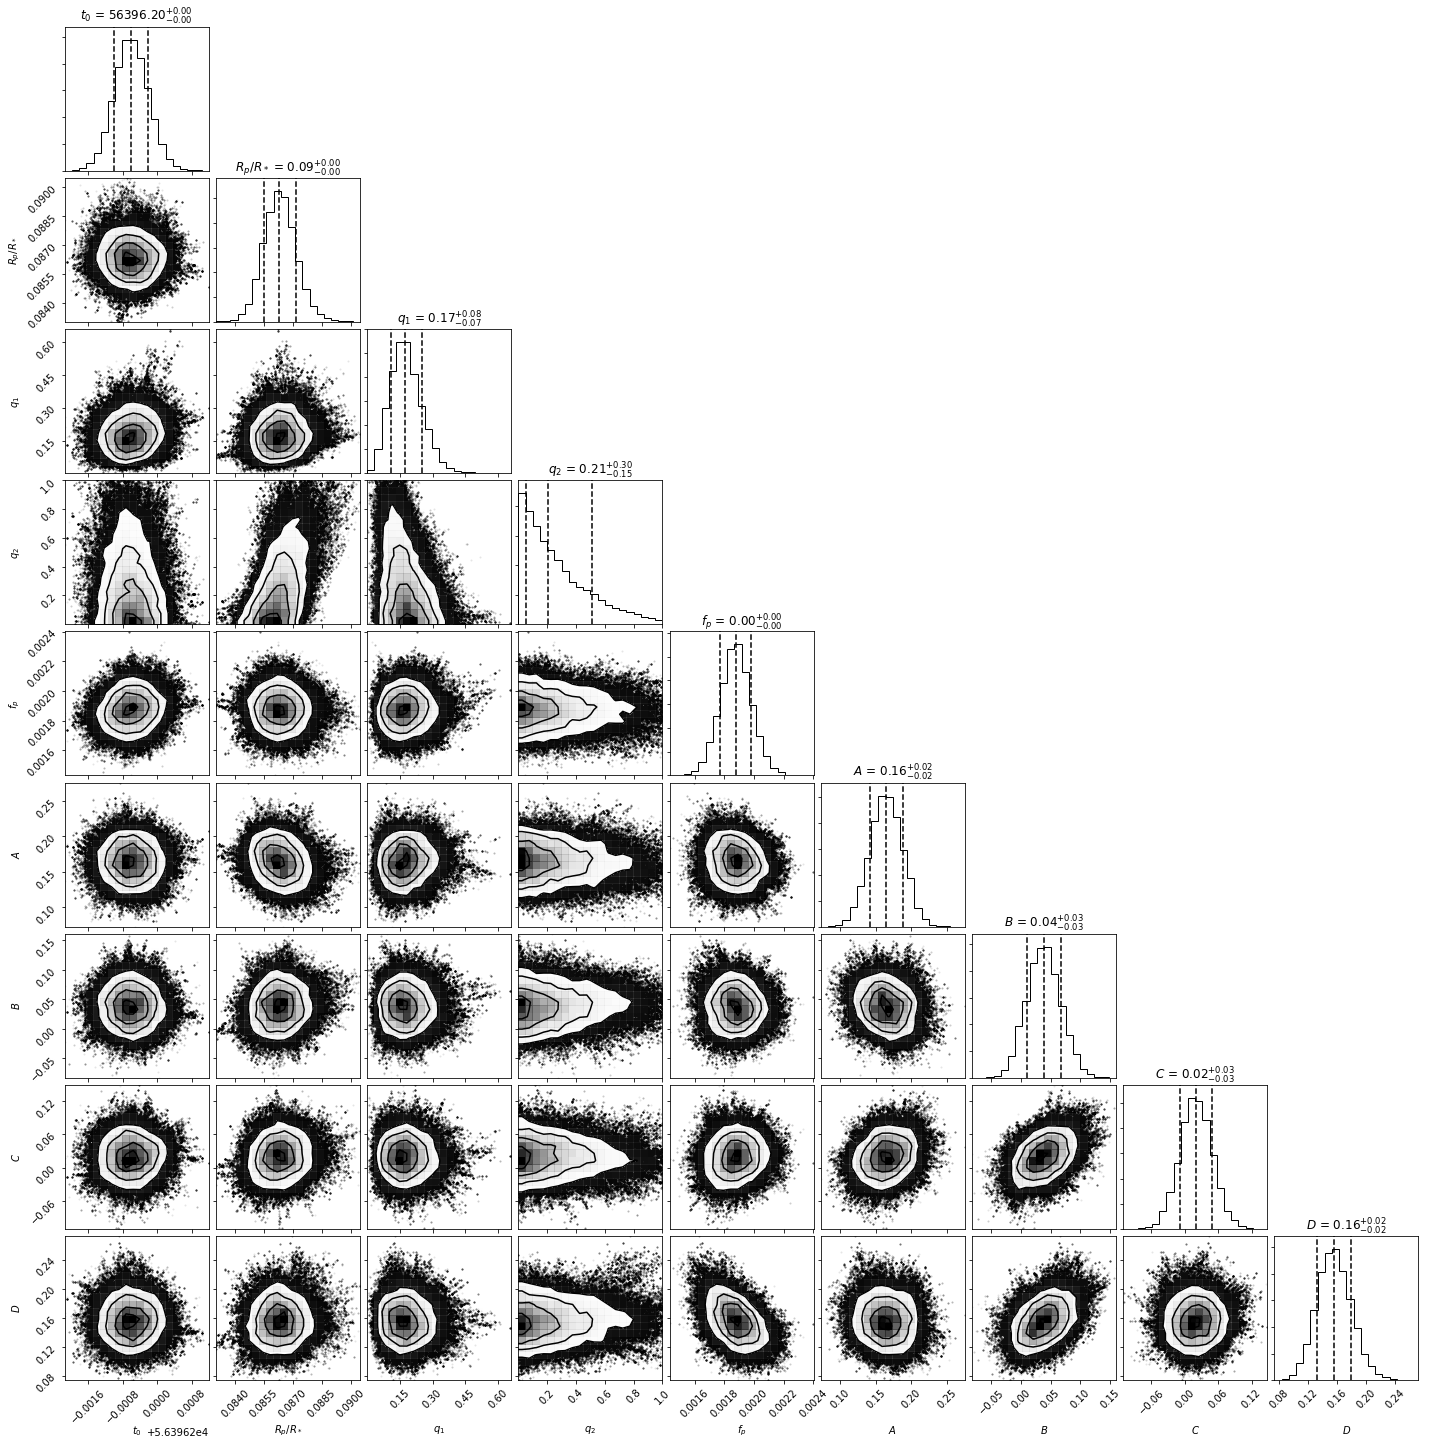

In [42]:
#save us some time when not running MCMC since this plot takes forever to make....
if runMCMC:
    fig = corner.corner(samples[:,:ind_a], labels=p0_fancyLabels, quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                        plot_datapoints=True, title_kwargs={"fontsize": 12})
    plotname = savepath + 'MCMC_'+mode+'_corner.pdf'
    fig.savefig(plotname, bbox_inches='tight')

In [43]:
if 'ecosw' in p0_labels and 'esinw' in p0_labels:
    '''Eccentricity and Longitude of Periastron Coefficient'''
    
    ind1 = np.where(p0_labels == 'ecosw')[0][0]
    ind2 = np.where(p0_labels == 'esinw')[0][0]
    e_chain = np.sqrt(samples[:,ind1]**2 + samples[:,ind2]**2)
    w_chain = np.arctan(samples[:,ind2]/samples[:,ind1])
    binse = np.linspace(np.min(e_chain), np.max(e_chain), 20)
    binsw = np.linspace(np.min(w_chain), np.max(w_chain), 20)
    
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
    axes[0,0].hist(samples[:,ind1], bins=np.linspace(np.min(samples[:,ind1]), np.max(samples[:,ind1]), 20), color='k', alpha=0.3)
    axes[0,1].hist(samples[:,ind2], bins=np.linspace(np.min(samples[:,ind2]), np.max(samples[:,ind2]), 20), color='k', alpha=0.3)
    axes[1,0].hist(e_chain, binse, color='k', alpha=0.3)
    axes[1,1].hist(w_chain, binsw, color='k', alpha=0.3)

    plt.setp(axes[0,0].get_yticklabels(), visible=False)
    plt.setp(axes[0,1].get_yticklabels(), visible=False)
    plt.setp(axes[1,0].get_yticklabels(), visible=False)
    plt.setp(axes[1,1].get_yticklabels(), visible=False)

    plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
    plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
    plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
    plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

    axes[0,0].set_title('$e \cos (\omega)$', fontsize=12)
    axes[0,1].set_title('$e \sin (\omega)$', fontsize=12)
    axes[1,0].set_title('$e$', fontsize=12)
    axes[1,1].set_title('$\omega$', fontsize=12)

    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.2)
    plotname = savepath + 'MCMC_'+mode+'_ecc-omega.pdf'
    fig.savefig(plotname, bbox_inches='tight')

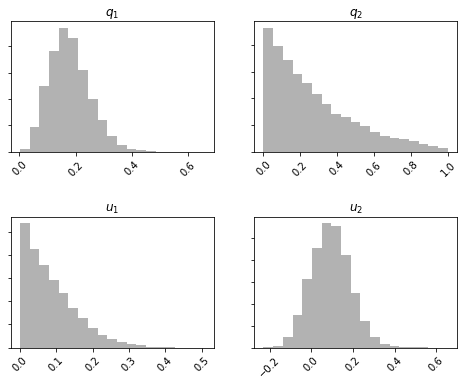

In [44]:
if 'q1' in p0_labels and 'q2' in p0_labels:
    '''Stellar Limb Darkening Parameters'''
    
    ind1 = np.where(p0_labels == 'q1')[0][0]
    ind2 = np.where(p0_labels == 'q2')[0][0]
    u1_chain = 2*np.sqrt(samples[:,ind1]**2)*samples[:,ind2]
    u2_chain = np.sqrt(samples[:,ind1]**2)*(1-2*samples[:,ind2])
    binsu1 = np.linspace(np.min(u1_chain), np.max(u1_chain), 20)
    binsu2 = np.linspace(np.min(u2_chain), np.max(u2_chain), 20)
    
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
    axes[0,0].hist(samples[:,ind1], bins=np.linspace(np.min(samples[:,ind1]), np.max(samples[:,ind1]), 20), color='k', alpha=0.3)
    axes[0,1].hist(samples[:,ind2], bins=np.linspace(np.min(samples[:,ind2]), np.max(samples[:,ind2]), 20), color='k', alpha=0.3)
    axes[1,0].hist(u1_chain, binsu1, color='k', alpha=0.3)
    axes[1,1].hist(u2_chain, binsu2, color='k', alpha=0.3)

    plt.setp(axes[0,0].get_yticklabels(), visible=False)
    plt.setp(axes[0,1].get_yticklabels(), visible=False)
    plt.setp(axes[1,0].get_yticklabels(), visible=False)
    plt.setp(axes[1,1].get_yticklabels(), visible=False)

    plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
    plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
    plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
    plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

    axes[0,0].set_title('$q_1$', fontsize=12)
    axes[0,1].set_title('$q_2$', fontsize=12)
    axes[1,0].set_title('$u_1$', fontsize=12)
    axes[1,1].set_title('$u_2$', fontsize=12)

    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.2)
    plotname = savepath + 'MCMC_'+mode+'_limbdark.pdf'
    fig.savefig(plotname, bbox_inches='tight')

In [52]:
#Clean out the RAM
samples = None
sampler = None
chain = None

In [45]:
# generate uniformly spaced time array for plot purposes
time2 = np.linspace(np.min(time), np.max(time), 1000)

# generate the models from best-fit parameters
mcmc_det        = detecfunc((xdata, ydata, mode), *(p0_mcmc[ind_a:ind_d]))
mcmc_psfwi      = psfwifunc(((psfxw, psfyw)), *(p0_mcmc[ind_d:ind_p]))
mcmc_lightplot  = astrofunc(time2, *p0_mcmc[:ind_a], mode)
mcmc_lightcurve = astrofunc(time, *p0_mcmc[:ind_a], mode)

# converting time into orbital phases
if 't0' in p0_labels:
    t0MCMC = p0_mcmc[np.where(p0_labels == 't0')[0][0]]
else:
    t0MCMC = p0_obj.t0
if 'per' in p0_labels:
    perMCMC = p0_mcmc[np.where(p0_labels == 'per')[0][0]]
else:
    perMCMC = p0_obj.per
x = (time-t0MCMC)/perMCMC
orbNum = int(np.min(x))
if np.min(x)<0:
    orbNum -= 0.5
else:
    orbNum += 0.5
x -= orbNum

orb_breaks = np.empty(len(breaks))
for j in range(len(breaks)):
    orb_breaks[j] = ((breaks[j]-t0MCMC)/perMCMC-orbNum)
orbperi = ((peritime-t0MCMC)/perMCMC-orbNum)

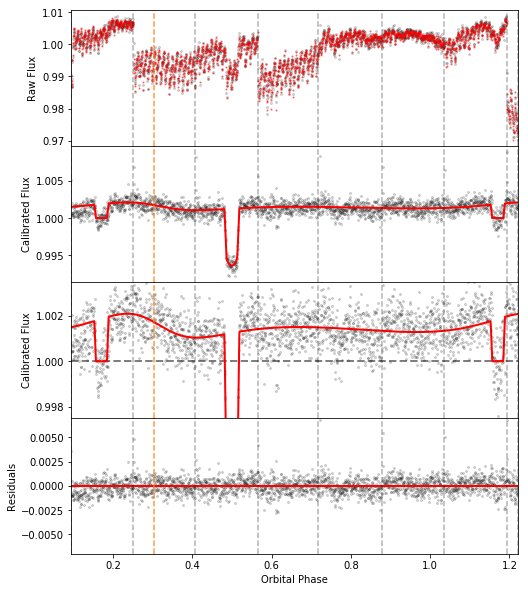

In [46]:
make_plots_custom.plot_bestfit(x, flux, mcmc_lightcurve, mcmc_det, mcmc_psfwi, 
                        mode, orb_breaks, savepath, orbperi)

In [47]:
#Noise vs bin-size to look for red noise
y = flux/(mcmc_det*mcmc_psfwi) - mcmc_lightcurve

sigmas = []
for i in range(3,len(y)):
    sigmas.append(helpers.binnedNoise(x,y,i))
sigmas = np.array(sigmas)

n_binned = len(y)/np.arange(3,len(y))

Over Ingress (17.8 min):
Expected Noise (ppm)	Observed Noise (ppm)
288.1375780301033	442.26360897644224
Observed/Expected
1.534904305089413

Over Transit/Eclipse (206.4 min):
Expected Noise (ppm)	Observed Noise (ppm)
84.60010591063613	202.50989905248412
Observed/Expected
2.3937310346442966


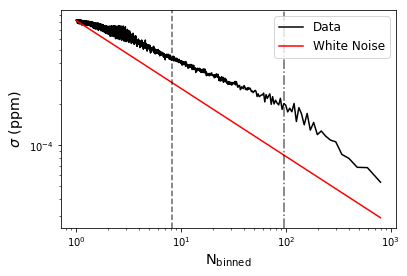

In [48]:
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

if 'sigF' in p0_labels:
    sigFMCMC = p0_mcmc[np.where(p0_labels == 'sigF')[0][0]]
else:
    sigFMCMC = p0_obj.sigF
if 'rp' in p0_labels:
    rpMCMC = p0_mcmc[np.where(p0_labels == 'rp')[0][0]]
else:
    rpMCMC = p0_obj.rp
if 'a' in p0_labels:
    aMCMC = p0_mcmc[np.where(p0_labels == 'a')[0][0]]
else:
    aMCMC = p0_obj.a
if 'per' in p0_labels:
    perMCMC = p0_mcmc[np.where(p0_labels == 'per')[0][0]]
else:
    perMCMC = p0_obj.per

#WARNING: these durations assume circular orbits!!!
eclDuration = (2*rpMCMC/(2*np.pi*aMCMC/perMCMC))/((time[1]-time[0])) #Eclipse/transit ingress time
trDuration = (2/(2*np.pi*aMCMC/perMCMC))/((time[1]-time[0])) #Transit/eclipse duration

ax.plot(n_binned, sigmas, c='black', label='Data')
ax.plot([n_binned[-1],n_binned[0]], [sigFMCMC, sigFMCMC/np.sqrt(n_binned[0])], c='red', label='White Noise')
ylim = ax.get_ylim()
plt.plot([eclDuration,eclDuration],ylim, color='black', ls='--', alpha=0.6)
plt.plot([trDuration,trDuration],ylim, color='black', ls='-.', alpha=0.6)
ax.set_ylim(ylim)
plt.ylabel(r'$\sigma$ (ppm)', fontsize='x-large')
plt.xlabel(r'N$_{\rm binned}$', fontsize='x-large')
plt.legend(loc='best', fontsize='large')
plotname = savepath + 'MCMC_'+mode+'_RedNoise.pdf'
plt.savefig(plotname, bbox_inches='tight')


#Figure out how much red noise we have

#Eclipse Duration
sreal = sigmas[np.where(n_binned<=eclDuration)[0][0]]*1e6
s0 = sigFMCMC/np.sqrt(n_binned[np.where(n_binned<=eclDuration)[0][0]])*1e6
outStr = 'Over Ingress ('+str(round(eclDuration*((time[1]-time[0]))*24*60, 1))+' min):\n'
outStr += 'Expected Noise (ppm)\t'+'Observed Noise (ppm)\n'
outStr += str(s0)+'\t'+str(sreal)+'\n'
outStr += 'Observed/Expected\n'
outStr += str(sreal/s0)+'\n\n'
#Transit Duration
sreal = sigmas[np.where(n_binned<=trDuration)[0][0]]*1e6
s0 = sigFMCMC/np.sqrt(n_binned[np.where(n_binned<=trDuration)[0][0]])*1e6
outStr += 'Over Transit/Eclipse ('+str(round(trDuration*((time[1]-time[0]))*24*60, 1))+' min):\n'
outStr += 'Expected Noise (ppm)\t'+'Observed Noise (ppm)\n'
outStr += str(s0)+'\t'+str(sreal)+'\n'
outStr += 'Observed/Expected\n'
outStr += str(sreal/s0)

print(outStr)
with open(plotname[:-3]+'txt','w') as file:
    file.write(outStr) 

# Is $\chi ^2$ improving?

In [49]:
#Binned data
data = (flux/(mcmc_det*mcmc_psfwi))
fit  = mcmc_lightcurve
if 'sigF' in p0_labels:
    sigFMCMC = p0_mcmc[np.where(p0_labels == 'sigF')[0][0]]
else:
    sigFMCMC = p0_obj.sigF
chisB = helpers.chi2(data, fit, sigFMCMC)
logLB = helpers.loglikelihood(data, fit, sigFMCMC)
EB = helpers.BIC(logLB, ndim, len(data))

'''Get model'''
det_full  = detecfunc((xdata_full, ydata_full, mode), *(p0_mcmc[ind_a:ind_d]))
psfw_full = psfwifunc((psfxw_full, psfyw_full), *(p0_mcmc[ind_d:ind_p]))
lc_full   = astrofunc(time_full, *p0_mcmc[:ind_a], mode)
model_full= det_full*lc_full*psfw_full

'''Get Fitted Uncertainty'''
ferr_full = sigFMCMC*np.sqrt(nFrames)

N = len(model_full)-np.sum((model_full).mask)

chis = helpers.chi2(flux_full, model_full, ferr_full)
logL = helpers.loglikelihood(flux_full, model_full, ferr_full)
E = helpers.BIC(logL, ndim, N)

out = """{0}
Likelihood: {1}
Evidence: {2}
$\chi ^2 = $ {3}
$\ln(L)=$ {4}
$E =${5}""".format(chisB, logLB, EB, chis, logL, E) 
with open(savepath+'EVIDENCE_'+mode+'.txt','w') as file:
    file.write(out)
print(out)

2419.0526338657123
Likelihood: 13551.52975832143
Evidence: 13442.628936258869
$\chi ^2 = $ 45928.25735687211
$\ln(L)=$ 603805.166181158
$E =$603638.0409959285


In [50]:
ResultMCMC_Params = Table()

for i in range(len(p0_labels)):
    ResultMCMC_Params[p0_labels[i]] = MCMC_Results[i]

ResultMCMC_Params['chi2B'] = [chisB]
ResultMCMC_Params['chi2datum'] = [chisB/len(flux)]
ResultMCMC_Params['logLB'] = [logLB]
ResultMCMC_Params['evidenceB'] = [EB]

ResultMCMC_Params['chi2'] = [chis]
ResultMCMC_Params['logL'] = [logL]
ResultMCMC_Params['evidence'] = [E]

pathres = savepath + 'ResultMCMC_'+mode+'_Params.npy'
np.save(pathres, ResultMCMC_Params)

In [51]:
# determining in-eclipse and in-transit index

# generating transit model

if 't0' in p0_labels:
    t0MCMC = p0_mcmc[np.where(p0_labels == 't0')[0][0]]
else:
    t0MCMC = p0_obj.t0
if 'per' in p0_labels:
    perMCMC = p0_mcmc[np.where(p0_labels == 'per')[0][0]]
else:
    perMCMC = p0_obj.per
if 'rp' in p0_labels:
    rpMCMC = p0_mcmc[np.where(p0_labels == 'rp')[0][0]]
else:
    rpMCMC = p0_obj.rp
if 'a' in p0_labels:
    aMCMC = p0_mcmc[np.where(p0_labels == 'a')[0][0]]
else:
    aMCMC = p0_obj.a
if 'inc' in p0_labels:
    incMCMC = p0_mcmc[np.where(p0_labels == 'inc')[0][0]]
else:
    incMCMC = p0_obj.inc
if 'ecosw' in p0_labels:
    ecoswMCMC = p0_mcmc[np.where(p0_labels == 'ecosw')[0][0]]
else:
    ecoswMCMC = p0_obj.ecosw
if 'esinw' in p0_labels:
    esinwMCMC = p0_mcmc[np.where(p0_labels == 'esinw')[0][0]]
else:
    esinwMCMC = p0_obj.esinw
if 'q1' in p0_labels:
    q1MCMC = p0_mcmc[np.where(p0_labels == 'q1')[0][0]]
else:
    q1MCMC = p0_obj.q1
if 'q2' in p0_labels:
    q2MCMC = p0_mcmc[np.where(p0_labels == 'q2')[0][0]]
else:
    q2MCMC = p0_obj.q2
if 'fp'in p0_labels:
    fpMCMC = p0_mcmc[np.where(p0_labels == 'fp')[0][0]]
else:
    fpMCMC = p0_obj.fp

eccMCMC = np.sqrt(ecoswMCMC**2 + esinwMCMC**2)
wMCMC   = np.arctan2(esinwMCMC, ecoswMCMC)
u1MCMC  = 2*np.sqrt(q1MCMC)*q2MCMC
u2MCMC  = np.sqrt(q1MCMC)*(1-2*q2MCMC)

trans, t_sec, true_anom = astro_models.transit_model(time, t0MCMC, perMCMC, rpMCMC,
                                                   aMCMC, incMCMC, eccMCMC, wMCMC,
                                                   u1MCMC, u2MCMC)
# generating secondary eclipses model
eclip = astro_models.eclipse(time, t0MCMC, perMCMC, rpMCMC, aMCMC, incMCMC, eccMCMC, wMCMC,
                             u1MCMC, u2MCMC, fpMCMC, t_sec)

# get in-transit indices
ind_trans  = np.where(trans!=1)
# get in-eclipse indices
ind_eclip  = np.where((eclip!=(1+fpMCMC)))
# seperating first and second eclipse
ind_ecli1 = ind_eclip[0][np.where(ind_eclip[0]<int(len(time)/2))]
ind_ecli2 = ind_eclip[0][np.where(ind_eclip[0]>int(len(time)/2))]


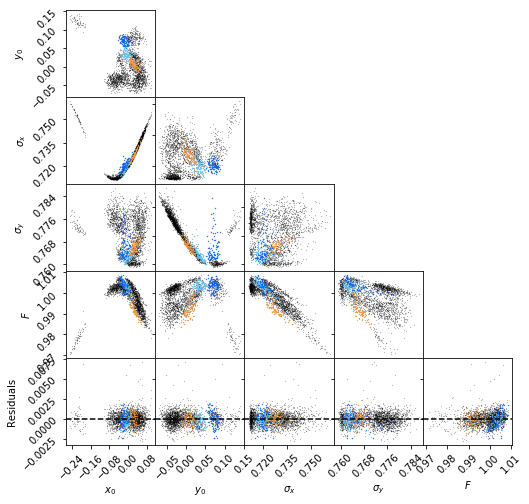

In [52]:
residual = flux/(mcmc_psfwi*mcmc_det) - mcmc_lightcurve

data1 = [xdata, ydata, psfxw, psfyw, flux, residual]
data2 = [xdata[ind_ecli1], ydata[ind_ecli1], psfxw[ind_ecli1], psfyw[ind_ecli1], flux[ind_ecli1], residual[ind_ecli1]]
data3 = [xdata[ind_trans], ydata[ind_trans], psfxw[ind_trans], psfyw[ind_trans], flux[ind_trans], residual[ind_trans]]
data4 = [xdata[ind_ecli2], ydata[ind_ecli2], psfxw[ind_ecli2], psfyw[ind_ecli2], flux[ind_ecli2], residual[ind_ecli2]]
label = [r'$x_0$', r'$y_0$', r'$\sigma _x$', r'$\sigma _y$', r'$F$', r'Residuals']

plotname = savepath + 'MCMC_'+mode+'_7.pdf'
helpers.triangle_colors(data1, data2, data3, data4, label, plotname)